In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bitalg.tests.test3 import Test
from bitalg.visualizer.main import Visualizer

# Definicja stałych

In [2]:
# math constant
INF = float("inf")

# determinant
EPS = 10 ** -12
LEFT = 1
RIGHT = -1
MIDDLE = 0

# verticies classification
START = 0
END = 1
CONNECT = 2
DIVIDE = 3
REGULAR = 4

# chain classification
BELONGS_TO_LEFT_CHAIN = 0
BELONGS_TO_RIGHT_CHAIN = 1

# Triangulacja wielokątów monotonicznych - problem monitorowania galerii


## Przydatne funkcje


In [3]:
polygon_example_1 = [(5,5), (3,4), (6,3), (4,2), (6,0), (7,1), (8,4)]
polygon_example_2 = [(2,0), (5,1), (6,0), (8,3), (7,2), (8,7), (6,9), (5,8), (2,9), (1,7), (2,4), (4,5), (3,6), (5, 7), (5.5, 3), (2,2), (1,3), (0,1)]
polygon_example_colors = [1, 3, 1, 0, 2, 4, 0, 2, 0, 4, 1, 4, 4, 3, 4, 2, 0, 4]
polygon_example_tri = [(polygon_example_1[0], polygon_example_1[2]),
                      (polygon_example_1[2], polygon_example_1[5]),
                      (polygon_example_1[2], polygon_example_1[6]),
                      (polygon_example_1[2], polygon_example_1[4])]

In [4]:
def draw_polygon(polygon):
    plt.close("all")
    vis = Visualizer()
    vis.add_polygon(polygon, fill=False)
    vis.show()

In [46]:
# TODO: choose appropriate option
def get_polygon_vis(polygon):
    plt.close("all")
    vis = Visualizer()
    vis.add_polygon(polygon, fill=False)
    return vis

In [5]:
def draw_polygon_colors(polygon,colors):
    plt.close('all')    # close all opened plots
    points_start=[]
    points_end=[]
    points_connect=[]
    points_divide=[]
    points_regular=[]
    for i in range(len(polygon)):
        if colors[i]==START:
            points_start.append(polygon[i])
        elif colors[i]==END:
            points_end.append(polygon[i])
        elif colors[i]==CONNECT:
            points_connect.append(polygon[i])
        elif colors[i]==DIVIDE:
            points_divide.append(polygon[i])
        elif colors[i]==REGULAR:
            points_regular.append(polygon[i])

    vis = Visualizer()
    colors_start = ['green']
    color_end=['red']
    color_connect=['blue']
    color_divide=['cyan']
    color_regular=['#3B240B']
    vis.add_polygon(polygon, fill=False)
    vis.add_point(points_start, color=colors_start)
    vis.add_point(points_end, color=color_end)
    vis.add_point(points_connect, color=color_connect)
    vis.add_point(points_divide, color=color_divide)
    vis.add_point(points_regular, color=color_regular)
    vis.show()

In [6]:
def draw_polygon_tri(polygon,tri):
    plt.close('all')    # close all opened plots
    vis = Visualizer()
    points = polygon
    tri_line_segments = tri
    vis.add_polygon(points, fill=False)
    vis.add_point(points)
    vis.add_line_segment(tri_line_segments, color='red')
    vis.show()

In [7]:
def get_polygon():
    # Event handler for mouse click
    def on_click(event):
        # Check if it's a left-click within the axes
        if event.button == 1 and event.inaxes == ax:
            # Append the point and update the plot
            currX, currY = event.xdata, event.ydata
            ax.scatter(currX, currY, color = "blue", marker = 'o')  # Mark the point

            # add polygon edge
            if len(points) >= 1:
                prevPointX, prevPointY = points[-1]
                xs = [prevPointX, currX]
                ys = [prevPointY, currY]
                ax.plot(xs, ys, color = "blue")

            points.append((currX, currY))
            plt.draw()

        # If right-click, close the polygon by connecting to the first point
        elif event.button == 3 and len(points) > 2:
            firstPointX, firstPointY = points[0]
            lastPointX, lastPointY = points[-1]
            xs = [firstPointX, lastPointX]
            ys = [firstPointY, lastPointY]
            ax.plot(xs, ys, color = "blue")
            fig.canvas.mpl_disconnect(cid)  # Disconnect the event
            plt.draw()

    # Connect the event handler
    plt.close('all')    # close all opened plots
    points = []
    fig, ax = plt.subplots(num = "get polygon")
    ax.set_title("Left-click to select points; right-click to close polygon")
    cid = fig.canvas.mpl_connect('button_press_event', on_click)
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.show()

    return points

In [39]:
def load_polygon_from_file(filename: str):
    """
    Odczytuje punkty z pliku i zwraca listę punktów jako krotki liczb zmiennoprzecinkowych.
    Każda linia w pliku powinna zawierać dwie liczby zmiennoprzecinkowe oddzielone spacją, reprezentujące współrzędne x i y punktu.

    :param filename: Nazwa pliku zawierającego punkty. Każda linia w pliku powinna zawierać dwie liczby zmiennoprzecinkowe oddzielone spacją.
    :return list of tuple: Lista, w której każdy element jest krotką reprezentującą punkt (x, y). Jeśli plik nie zostanie znaleziony lub zawiera nieprawidłowe dane, zwracana jest pusta lista.
    """
    points = []
    try:
        with open(filename, 'r') as file:
            for line in file:
                x, y = map(np.float64, line.strip().split())
                points.append((x, y))
    except FileNotFoundError:
        print(f"File '{filename}' not found.")
    except ValueError:
        print("Invalid format in file. Each line should contain two floats separated by a space.")
    return points


In [9]:
def mat_det_3x3(a, b, c):
    """
    Obliczanie wyznacznika macierzy 3x3 bez użycia funkcji bibliotecznych

    :param a: krotka współrzędnych (x, y) pierwszego punktu tworzącego naszą prostą
    :param b: krotka współrzędnych (x, y) drugiego punktu tworzącego naszą prostą
    :param c: krotka współrzędnych (x, y) punktu, którego położenie względem prostej chcemy znaleźć
    :return: wartość wyznacznika macierzy
    """
    ax, ay = a
    bx, by = b
    cx, cy = c

    return ax*by + bx*cy + cx*ay - (by*cx + cy*ax + ay*bx)

In [10]:
def orient(a, b, c):
    """
    Wyznaczenie położenia punktu c względem prostej ab

    :param a: krotka współrzędnych (x, y) pierwszego punktu tworzącego naszą prostą
    :param b: krotka współrzędnych (x, y) drugiego punktu tworzącego naszą prostą
    :param c: krotka współrzędnych (x, y) punktu, którego położenie względem prostej chcemy znaleźć
    :return: 0 - punkt leży na prostej, 1 punkt leży na lewo od prostej, -1 punkt leży na prawo od prostej
    """
    det = mat_det_3x3(a, b, c)
    if abs(det) <= EPS:
        return 0
    elif det > 0:
        return 1
    else:
        return -1

## Wprowadzenie
Celem ćwiczenia jest:
- sprawdzanie $y$-monotoniczności
- podział wierchołków na kategorie
- triangulacja wielokąta monotonicznego

### Przykładowy wielokąt $y$-monotoniczny

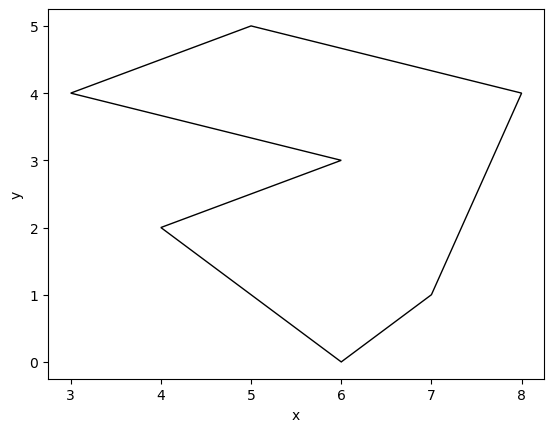

In [11]:
%matplotlib inline
draw_polygon(polygon_example_1)

Do tego celu wygeneruj wielokąt.

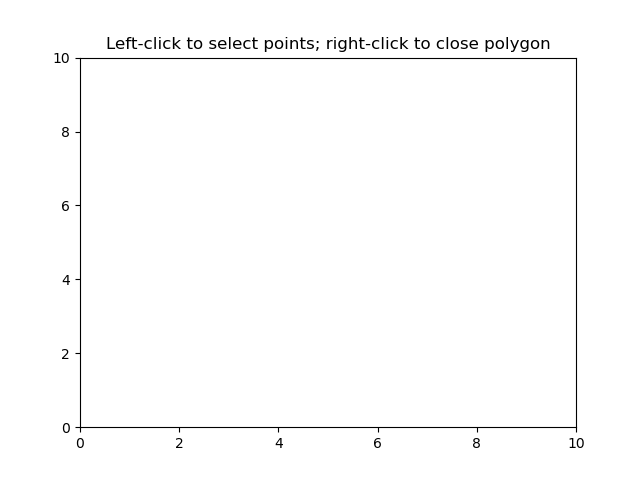

In [12]:
%matplotlib ipympl
polygon = get_polygon()

## Czy wielokąt jest $y$-monotoniczny?

Wielokąt jest monotoniczny, gdy jego wierzchołki mogą być ułożone w taki sposób, że jedna z jego współrzędnych (na przykład współrzędna $x$ lub $y$, w zależności od układu współrzędnych) zawsze rośnie lub maleje wzdłuż kolejnych wierzchołków. Innymi słowy, dla każdej pary wierzchołków wielokąta (oprócz wierzchołka startowego i końcowego), jeden z punktów ma większą (lub mniejszą) wartość danej współrzędnej niż drugi punkt.

W praktyce, wielokąt monotoniczny może być łatwiej sortowany lub przetwarzany w pewnych algorytmach geometrycznych, ponieważ istnieje pewna kolejność, w jakiej wierzchołki pojawiają się wzdłuż danej osi (np. osi $x$ lub $y$). Monotoniczność może ułatwić znajdowanie przecięć linii w takim wielokącie lub wykonywanie innych operacji geometrycznych. W tym zadaniu interesuje nas monotoniczność wielokąta wzdłuż osi $y$.

<span style="color:red">Ćw.</span> Uzupełnij funkcję ```is_y_monotonic```. Pamiętaj, aby sprawozdanie zawierało krótki opis działania tej funkcji.

In [13]:
def get_min_and_max_y(polygon):
    """
    Wyznaczenie punktu końcowego oraz początkowego w danym wielokacie

    :param polygon: list krotek współrzędnych (x, y) reprezentujących wielokat
    :return: minYPoint - punkt końcowy, maxYPoint - punkt startowy
    """
    minYPoint = polygon[0]
    maxYPoint = polygon[0]

    for point in polygon:
        _, y = point
        if y < minYPoint[1]:
            minYPoint = point
        elif y > maxYPoint[1]:
            maxYPoint = point

    return minYPoint, maxYPoint

In [14]:
def get_organized_polygon(polygon, maxYPoint):
    """
    Szereguje punkty w wielokącie tak, aby lista punktów zaczynała się od wierzchołka początkowego (maxYPoint)

    :param polygon: list krotek współrzędnych (x, y) reprezentujących wielokat
    :param maxYPoint: wierzchołek początkowy wielokata
    :return oraganizedPolygon: wielokąt zaczynający się od wierzchołka początkowego
    """
    n = len(polygon)
    maxYPointIdx = polygon.index(maxYPoint)
    first = polygon[maxYPointIdx:]
    second = polygon[:maxYPointIdx]
    organizedPolygon = [(first[idx - maxYPointIdx], idx) for idx in range(maxYPointIdx, n)] + [(second[idx], idx) for idx in range(maxYPointIdx)]

    return organizedPolygon

In [15]:
def get_chains(organizedPolygon: list, minYPoint):
    """
    Wyznacza lewy i prawy łańcuch uszeregowanego wielokąta, przy czym wierzchołek początkowy należy do lewego
    łańcucha a wierzchołek końcowy do prawego łańcucha

    :param organizedPolygon: wielokat zaczynający się od wierzchołka początkowego
    :param minYPoint: wierzchołek końcowy wielokata
    :return (leftChain, rightChain): krotka list zawierających lewy i prawy łańcuch uszeregowanego wielokata
    """
    minYPointIdx = 0

    while organizedPolygon[minYPointIdx][0] != minYPoint:
        minYPointIdx += 1

    leftChain = organizedPolygon[:minYPointIdx]
    rightChain = organizedPolygon[minYPointIdx:]
    rightChain.reverse()
    return leftChain, rightChain

In [16]:
def is_y_monotonic(polygon):
    """
    Funkcja określa czy podana figura jest y-monotoniczna.

    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: wartość bool - true, jeśli wielokąt jest monotoniczny i false jeśli nie jest
    """
    minYPoint, maxYPoint = get_min_and_max_y(polygon)
    organizedPolygon = get_organized_polygon(polygon, maxYPoint)
    leftChain, rightChain = get_chains(organizedPolygon, minYPoint)
    leftChainLen = len(leftChain)
    rightChainLen = len(rightChain)

    # sprawdzenie lewego łańcucha
    for i in range(1, leftChainLen):
        currY = leftChain[i][0][1]
        prevY = leftChain[i - 1][0][1]

        if currY > prevY:
            return False

    # sprawdzenie prawego łańcucha
    for i in range(1, rightChainLen):
        currY = rightChain[i][0][1]
        prevY = rightChain[i - 1][0][1]

        if currY > prevY:
            return False

    return True

Przeprowadź test poprawności powyższej funkcji.

In [17]:
Test().runtest(1, is_y_monotonic)

Lab 3, task 1:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
	Test 4: Passed
	Test 5: Passed
	Test 6: Passed
	Test 7: Passed
	Test 8: Passed
	Test 9: Passed
	Test 10: Passed
Result: 10/10
Time: 0.003s


Sprawdź monotoniczność swojego wielokątu.

In [18]:
print(is_y_monotonic(polygon))

True


***

# Podział wierzchołków na kategorie

Wierzchołki naszego wielokąta możemy podzielić na parę kategorii:
- początkowe, gdy obaj jego sąsiedzi leżą poniżej i kąt wewnętrzny ma mniej niż 180 stopni. To wierzchołki, w których zaczyna się monotoniczny spadek
- końcowe, gdy obaj jego sąsiedzi leżą powyżej i kąt wewnętrzny ma mniej niż 180 stopni. To wierzchołki, w których monotoniczność wielokąta się zmienia, czyli na przykład zaczyna się monotoniczny wzrost, jeśli wcześniej był spadek, lub na odwrót.

Wierzchołki startowe i końcowe są ważne w kontekście algorytmów przetwarzania wielokątów monotonicznych, takich jak algorytmy dziel i zwyciężaj oraz triangulacji.
- dzielący, gdy obaj jego sąsiedzi leżą poniżej i kąt wewnęntrzny ma więcej niż 180 stopni. To wierzchołki, które wyznaczają przekątne (linie łączące), tworzące trójkąty podczas triangulacji.
- łączący, gdy obaj jego sąsiedzi leżą powyżej i kąt wewnęntrzny ma więcej niż 180 stopni. To wierzchołki, które są połączone liniami (przekątnymi) wewnątrz wielokąta, tworząc trójkąty.

Wierzchołki łączące i dzielące odgrywają kluczową rolę w procesie triangulacji wielokątów, pozwalając na podział figury na trójkąty w sposób bezkolizyjny.
- prawidłowy, pozostałe przypadki, jeden sąsiad powyżej, drugi poniżej


### Przykładowy wielokąt z pokolorowanymi wierzchołkami.

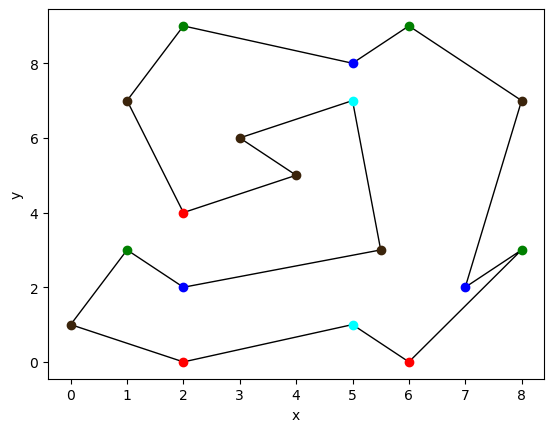

In [19]:
%matplotlib inline
draw_polygon_colors(polygon_example_2,polygon_example_colors)

<span style="color:red">Ćw.</span> Uzupełnij funkcję ```color_vertex``` .

In [20]:
def classify_vertex(prev, vertex, next):
    """
    Funkcja klasyfikuje wierzchołek vertex na podstawie jego sąsiadów

    :param prev: wierzchołek poprzedzający wierzchołek vertex
    :param vertex: wierzchołek do sklasyfikowania
    :param next: wierzchołek następujący po wierzchołeku vertex
    :return: liczbę 0 - 4 odpowiadającą klasyfikacji wierzchołka vertex
    """
    prevY = prev[1]
    y = vertex[1]
    nextY = next[1]

    if prevY > y:
        if nextY < y:
            return REGULAR

        nextOrient = orient(prev, vertex, next)
        if nextOrient == LEFT:
            return END
        else:
            return CONNECT
    else:
        if nextY > y:
            return REGULAR

        nextOrient = orient(prev, vertex, next)
        if nextOrient == LEFT:
            return START
        else:
            return DIVIDE


In [21]:
def color_vertex(polygon):
    """
    Funkcja dzieli wierzchołki na kategorie i przypisuje wierzchołkom odpowiednie numery: 0 - początkowy, 1 - końcowy,
    2 - łączący, 3 - dzielący, 4 - prawdiłowy

    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: tablica o długości n, gdzie n = len(polygon), zawierająca cyfry z przedziału 0 - 4, gdzie T[i] odpowiada kategorii i-tego wierzchołka.
    """

    n = len(polygon)

    firstPointClassyfication =  classify_vertex(polygon[n-1], polygon[0], polygon[1])
    verticiesClasyfication = [firstPointClassyfication]

    for i in range(1, n - 1):
        prev = polygon[i - 1]
        vertex = polygon[i]
        next = polygon[i + 1]
        verticiesClasyfication.append(classify_vertex(prev, vertex, next))

    # TODO
    lastPointClassyfication = classify_vertex(polygon[n - 2], polygon[n - 1], polygon[0])
    verticiesClasyfication.append(lastPointClassyfication)

    return verticiesClasyfication

Przeprowadź test poprawności powyższej funkcji. 

In [22]:
Test().runtest(2, color_vertex)

Lab 3, task 2:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
	Test 4: Passed
	Test 5: Passed
	Test 6: Passed
	Test 7: Passed
	Test 8: Passed
	Test 9: Passed
	Test 10: Passed
Result: 10/10
Time: 0.004s


Zwizualizuj swój wielokąt z pokolorowanymi według kategorii wierzchołkami.

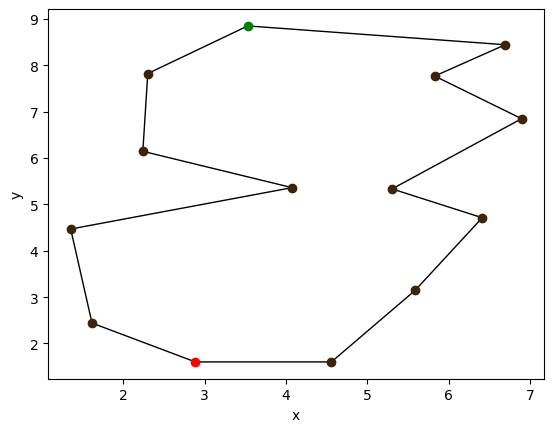

In [23]:
%matplotlib inline
colors = color_vertex(polygon)
draw_polygon_colors(polygon,colors)

***

# Triangulacja wielokąta monotonicznego

Triangulacja wielokąta monotonicznego to proces podziału wielokąta monotonicznego na trójkąty poprzez dodawanie przekątnych (linii łączących wierzchołki), które nie przecinają się wewnętrznie.

### Przykładowy wielokąt podzielony na trójkąty.

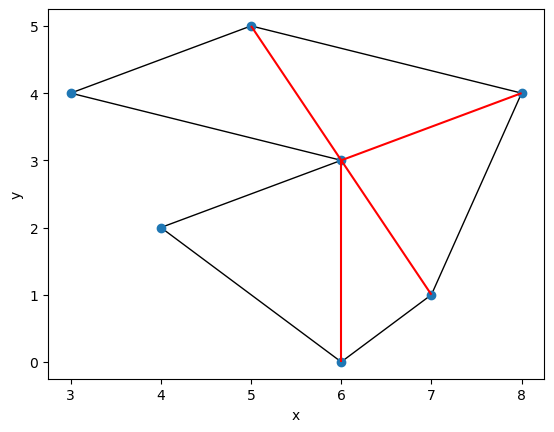

In [24]:
%matplotlib inline
draw_polygon_tri(polygon_example_1, polygon_example_tri)

<span style="color:red">Ćw.</span> Uzupełnij funkcję ```triangulation```. Wykorzystaj algorytm opisany na wykładzie.

In [25]:
class PointsQueue:
    def __init__(self, leftChain, rightChain):
        self.leftChain = leftChain
        self.rightChain = rightChain
        self.leftChainLen = len(self.leftChain)
        self.rightChainLen = len(self.rightChain)
        self.leftChainIdx = 0
        self.rightChainIdx = 0

    def is_left_chain_empty(self):
        return self.leftChainIdx >= self.leftChainLen

    def is_right_chain_empty(self):
        return self.rightChainIdx >= self.rightChainLen

    def is_empty(self):
        return self.is_left_chain_empty and self.is_right_chain_empty()

    def get(self):
        if self.is_left_chain_empty():
            item = (*self.rightChain[self.rightChainIdx], BELONGS_TO_RIGHT_CHAIN)
            self.rightChainIdx += 1
            return item
        elif self.is_right_chain_empty():
            item = (*self.leftChain[self.leftChainIdx], BELONGS_TO_LEFT_CHAIN)
            self.leftChainIdx += 1
            return item

        leftChainPoint, leftChainPointIdx = self.leftChain[self.leftChainIdx]
        leftChainPointY = leftChainPoint[1]
        rightChainPoint, rightChainPointIdx = self.rightChain[self.rightChainIdx]
        rightChainPointY = rightChainPoint[1]
        item = None
        if leftChainPointY > rightChainPointY:
            self.leftChainIdx += 1
            item = (leftChainPoint, leftChainPointIdx, BELONGS_TO_LEFT_CHAIN)
        else:
            self.rightChainIdx += 1
            item = (rightChainPoint, rightChainPointIdx, BELONGS_TO_RIGHT_CHAIN)

        return item

    def __len__(self):
        return self.leftChainLen + self.rightChainLen

In [26]:
def are_neighbours(polygon, vertexIdx1, vertexIdx2):
    n = len(polygon)
    diff = abs(vertexIdx1 - vertexIdx2)
    return diff == 1 or diff == n - 1

In [64]:
def is_inside_polygon(stackNextToTopPoint, stackTopPoint, point, pointClassification):
    return orient(stackNextToTopPoint, stackTopPoint, point) == LEFT \
           if pointClassification == BELONGS_TO_LEFT_CHAIN \
           else orient(stackNextToTopPoint, stackTopPoint, point) == RIGHT

In [88]:
def add_diagonal(diagonals: list, polygon, vertexIdx1, vertexIdx2):
    if not are_neighbours(polygon, vertexIdx1, vertexIdx2):
        diagonals.append((vertexIdx1, vertexIdx2))

In [131]:
def stack_top_in_the_same_chain(polygon, diagonals, stack: list, currPoint):
    point, pointIdx, classification = currPoint
    for stackPoint, stackPointIdx, stackPointClassification in stack:
        add_diagonal(diagonals, polygon, pointIdx, stackPointIdx)

    return [stack[-1], currPoint]

In [130]:
def stack_top_in_different_chain(polygon, diagonals, stack: list, currPoint):
    point, pointIdx, classification = currPoint
    while len(stack) > 1:
        stackTop = stack[-1]
        stackTopPoint, stackTopPointIdx, stackTopPointClassification = stackTop
        stackNextToTop = stack[-2]
        stackNextToTopPoint, stackNextToTopPointIdx, stackNextToTopClassification = stackNextToTop

        # check if triangle DOES NOT lay inside polygon
        if not is_inside_polygon(stackNextToTopPoint, stackTopPoint, point, classification):
            break

        add_diagonal(diagonals, polygon, pointIdx, stackNextToTopPointIdx)
        stack.pop()

    stack.append(currPoint)

    return stack

In [132]:
def triangulation(polygon):
    """
    Funkcja dokonuje triangulacji wielokąta monotonicznego.

    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: tablica krotek dodawanych po kolei przekątnych np: [(1,5),(2,3)], oznacza, że triangulacja polega na dodaniu przekątnej
    pomiędzy wierzchołki o indeksach 1 i 5 oraz 2 i 3
    """
    diagonals = []

    minYPoint, maxYPoint = get_min_and_max_y(polygon)
    leftChain, rightChain = get_chains(get_organized_polygon(polygon, maxYPoint), minYPoint)
    pointsQueue = PointsQueue(leftChain, rightChain)

    stack = [pointsQueue.get() for _ in range(2)]

    while not pointsQueue.is_empty():
        currPoint = pointsQueue.get()
        point, pointIdx, classification = currPoint

        stackTop = stack[-1]
        stackTopPoint, stackTopPointIdx, stackTopPointClassification = stackTop

        if classification != stackTopPointClassification:
            stack = stack_top_in_the_same_chain(polygon, diagonals, stack, currPoint)
        else:
            stack = stack_top_in_different_chain(polygon, diagonals, stack, currPoint)

    return diagonals

[(np.float64(-0.0011310497406990389), np.float64(0.05034364616169651)), (np.float64(-0.03018346909553775), np.float64(0.03686325400483377)), (np.float64(-0.042159275547150654), np.float64(0.0038362932205200373)), (np.float64(-0.02641330780521517), np.float64(-0.029190667563793703)), (np.float64(0.0006431438076880541), np.float64(-0.046041157759872144)), (np.float64(0.027477821227042898), np.float64(-0.029527677367715277)), (np.float64(0.03235685348510742), np.float64(0.001140214789147484)), (np.float64(0.028586692194784838), np.float64(0.02911202851463769))]
[(7, 1), (2, 7), (6, 2), (3, 6), (5, 3)]


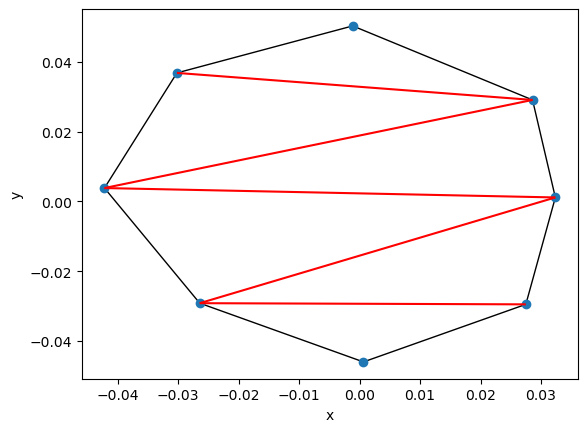

In [133]:
%matplotlib inline
# polygonFromFile = load_polygon_from_file("/home/wiktor/university/sem3/geometrical_algorithms/bit-algo-vis-tool/bitalg/tests/test3_tests/task3/test_3_3_1.in")
polygonFromFile = load_polygon_from_file("/home/wiktor/university/sem3/geometrical_algorithms/bit-algo-vis-tool/bitalg/tests/test3_tests/task3/test_3_3_2.in")
# polygonFromFile = load_polygon_from_file("/home/wiktor/university/sem3/geometrical_algorithms/bit-algo-vis-tool/bitalg/tests/test3_tests/task3/test_3_3_3.in")
# polygonFromFile = load_polygon_from_file("/home/wiktor/university/sem3/geometrical_algorithms/bit-algo-vis-tool/bitalg/tests/test3_tests/task3/test_3_3_4.in")
# polygonFromFile = load_polygon_from_file("/home/wiktor/university/sem3/geometrical_algorithms/bit-algo-vis-tool/bitalg/tests/test3_tests/task3/test_3_3_5.in")
# polygonFromFile = load_polygon_from_file("/home/wiktor/university/sem3/geometrical_algorithms/bit-algo-vis-tool/bitalg/tests/test3_tests/task3/test_3_3_6.in")
# polygonFromFile = load_polygon_from_file("/home/wiktor/university/sem3/geometrical_algorithms/bit-algo-vis-tool/bitalg/tests/test3_tests/task3/test_3_3_7.in")
# polygonFromFile = load_polygon_from_file("/home/wiktor/university/sem3/geometrical_algorithms/bit-algo-vis-tool/bitalg/tests/test3_tests/task3/test_3_3_8.in")
# polygonFromFile = load_polygon_from_file("/home/wiktor/university/sem3/geometrical_algorithms/bit-algo-vis-tool/bitalg/tests/test3_tests/task3/test_3_3_9.in")
# polygonFromFile = load_polygon_from_file("/home/wiktor/university/sem3/geometrical_algorithms/bit-algo-vis-tool/bitalg/tests/test3_tests/task3/test_3_3_10.in")
print(polygonFromFile)
tri = triangulation(polygonFromFile)
print(tri)
draw_polygon_tri(polygonFromFile, [(polygonFromFile[x], polygonFromFile[y]) for (x, y) in tri])

Jakich struktur można użyć do przechowywania wielokątu, oraz utworzonej triangulacji? Uzasadnij wybór struktury w swoim algorytmie

ODPOWIEDŹ: 

Przeprowadź testy poprawności powyższej funkcji.


In [134]:
Test().runtest(3, triangulation)

Lab 3, task 3:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
	Test 4: Passed
	Test 5: Passed
	Test 6: Passed
	Test 7: Passed
	Test 8: Passed
	Test 9: Passed
	Test 10: Passed
Result: 10/10
Time: 0.003s


Zwizualizuj powstały wielokąt podzielony na trójkąty.

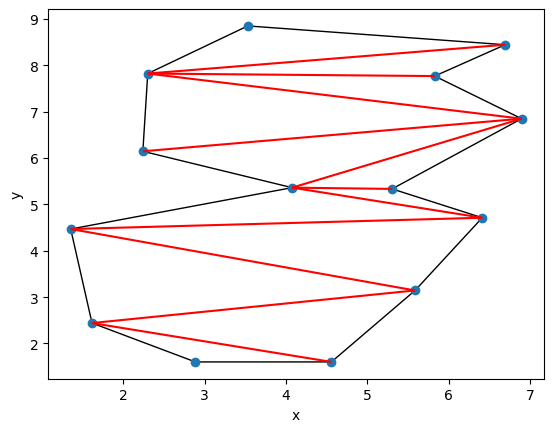

In [135]:
tri = triangulation(polygon)
draw_polygon_tri(polygon, [(polygon[x], polygon[y]) for (x, y) in tri])